In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.animation as animation
import geopandas as gpd
from cartopy import crs as ccrs
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
# shapefile from https://www12.statcan.gc.ca/census-recensement/2011/geo/bound-limit/bound-limit-2016-eng.cfm
# cite as : Boundary Files, 2016 Census. Statistics Canada Catalogue no. 92-160-X
province = gpd.read_file('./GIS Data/Canada/lpr_000b16a_e.shp')
codes = ["NL","PE","NS","NB","QC","ON","MB","SK","AB","BC","YT","NT","NU"]
province["ID"] = codes
province.head()

,PRUID,PRNAME,PRENAME,PRFNAME,PREABBR,PRFABBR,geometry,ID
0,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,Newfoundland and Labrador,Terre-Neuve-et-Labrador,N.L.,T.-N.-L.,"MULTIPOLYGON (((8307365.589 2582136.711, 83083...",NL
1,11,Prince Edward Island / Île-du-Prince-Édouard,Prince Edward Island,Île-du-Prince-Édouard,P.E.I.,Î.-P.-É.,"MULTIPOLYGON (((8435711.754 1679935.966, 84358...",PE
2,12,Nova Scotia / Nouvelle-Écosse,Nova Scotia,Nouvelle-Écosse,N.S.,N.-É.,"MULTIPOLYGON (((8470851.646 1624745.011, 84710...",NS
3,13,New Brunswick / Nouveau-Brunswick,New Brunswick,Nouveau-Brunswick,N.B.,N.-B.,"MULTIPOLYGON (((8176224.537 1722553.460, 81762...",NB
4,24,Quebec / Québec,Quebec,Québec,Que.,Qc,"MULTIPOLYGON (((8399709.494 2261445.703, 84005...",QC


In [3]:
states = gpd.read_file('./GIS Data/US/cb_2018_us_state_20m.shp')
states.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,24,01714934,0400000US24,24,MD,Maryland,00,25151100280,6979966958,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ..."
1,19,01779785,0400000US19,19,IA,Iowa,00,144661267977,1084180812,"POLYGON ((-96.62187 42.77925, -96.57794 42.827..."
2,10,01779781,0400000US10,10,DE,Delaware,00,5045925646,1399985648,"POLYGON ((-75.77379 39.72220, -75.75323 39.757..."
3,39,01085497,0400000US39,39,OH,Ohio,00,105828882568,10268850702,"MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ..."
4,42,01779798,0400000US42,42,PA,Pennsylvania,00,115884442321,3394589990,"POLYGON ((-80.51989 40.90666, -80.51964 40.987..."


In [4]:
## merge both datasets
canada = gpd.GeoDataFrame()
canada["ID"] = province["ID"]
canada["geometry"] = province["geometry"]
canada = canada.to_crs("EPSG:3395") # Spherical Mercator

# remove hawaii and other extra-continental
states = states[np.logical_not(states["STUSPS"].isin(["HI","VI","PR","AS","GU","MP","AK"]))]

us = gpd.GeoDataFrame()
us["ID"] = states["STUSPS"]
us["geometry"] = states["geometry"]
us = us.to_crs("EPSG:3395") # Spherical Mercator

places = pd.concat([canada, us], ignore_index=True)
places.head()

,ID,geometry
0,NL,"MULTIPOLYGON (((-6390025.857 7163888.320, -638..."
1,PE,"MULTIPOLYGON (((-6899916.801 5823023.215, -689..."
2,NS,"MULTIPOLYGON (((-6890936.419 5730258.184, -689..."
3,NB,"MULTIPOLYGON (((-7213675.170 6042579.261, -721..."
4,QC,"MULTIPOLYGON (((-6528556.268 6624871.363, -652..."


In [13]:
# data from https://droughtmonitor.unl.edu/CurrentMap.aspx
files = ["USDM_20211123.shp","USDM_20211130.shp","USDM_20211207.shp","USDM_20211214.shp"]
drought = list()

for file in files:
    data = gpd.read_file('./GIS Data/US/'+file)
    data = data.to_crs("EPSG:3395") # Spherical Mercator
    drought.append(data)

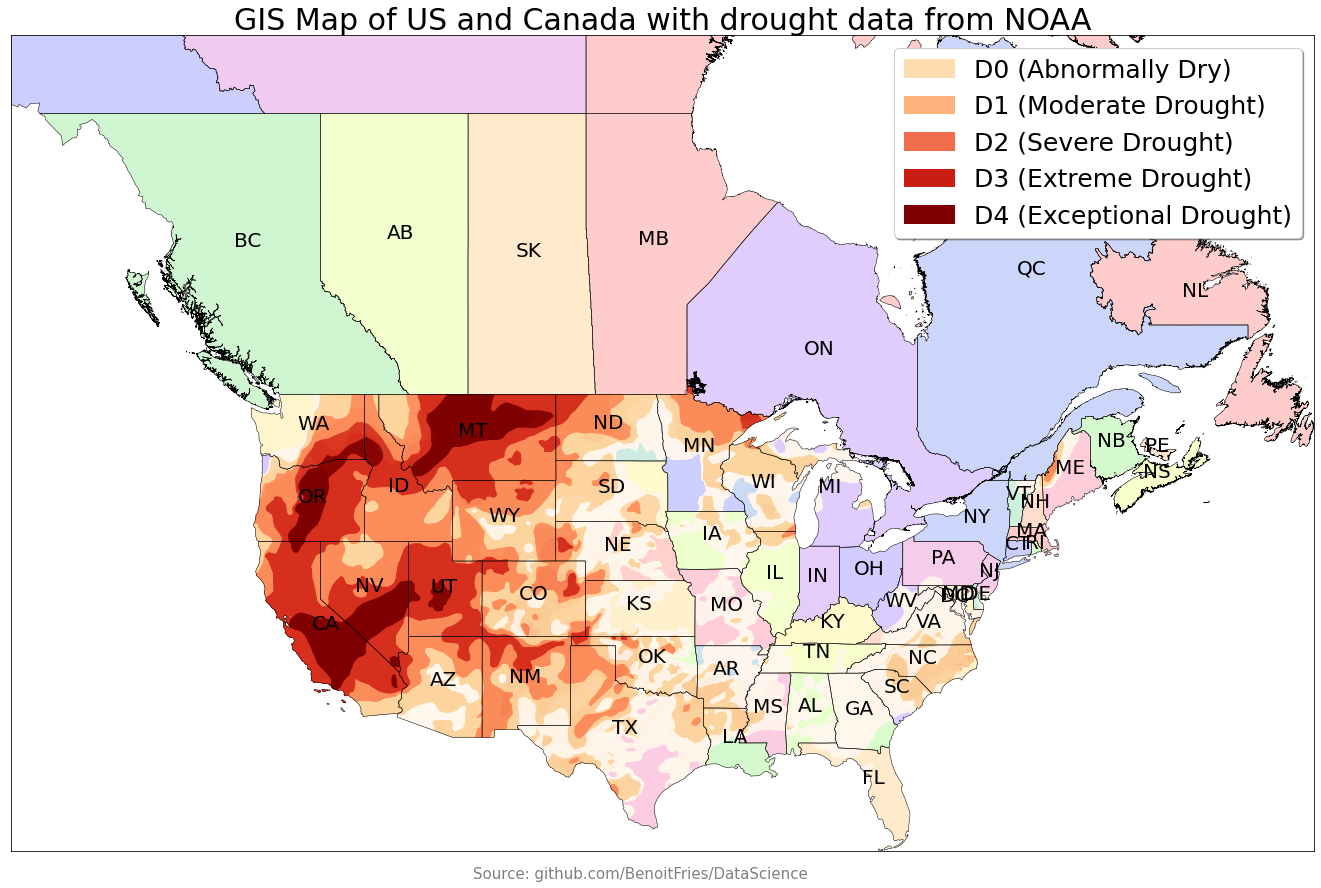

In [16]:
fig = plt.figure(1, figsize=(25,15)) 
ax = fig.add_subplot()
places.plot(ax=ax, cmap="prism", alpha=.2)

places.apply(lambda x: ax.annotate(text=x.ID, xy=x.geometry.centroid.coords[0], ha='center', fontsize=20),axis=1);
places.boundary.plot(ax=ax, color='k', linewidth=.5)

# zoom in (north of canada takes too much space)
minx, miny, maxx, maxy = places.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy/2)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

colormap = plt.cm.OrRd
    
d0 = mpatches.Patch(color=colormap(0.2), label='D0 (Abnormally Dry)')
d1 = mpatches.Patch(color=colormap(0.4), label='D1 (Moderate Drought)')
d2 = mpatches.Patch(color=colormap(0.6), label='D2 (Severe Drought)')
d3 = mpatches.Patch(color=colormap(0.8), label='D3 (Extreme Drought)')
d4 = mpatches.Patch(color=colormap(1.0), label='D4 (Exceptional Drought)')

ax.legend(handles=[d0,d1,d2,d3,d4], fancybox=True, shadow=True, fontsize=25)

plt.title('GIS Map of US and Canada with drought data from NOAA', fontdict={"fontsize":30} )
plt.figtext(0.5, 0.1, 'Source: github.com/BenoitFries/DataScience', 
            horizontalalignment='center', alpha=0.5, fontsize=15) 

def animate(i):
    drought[i].plot(ax=ax, cmap=colormap, alpha=0.9)

ani = animation.FuncAnimation(fig, animate, 4, interval=500, blit=False)
ani.save("NorthAmerica_Map_Drought.mp4")
plt.savefig("NorthAmerica_Map_Drought.png")
plt.show()